# Chapter 5: Finding optimal restrictions via action elimination

This notebook contains the Smart Home experiment presented in Chapter 5 of the thesis. 

In the experiment, agents act on an environment consisting of binary attributes: At every step, they each choose one (or no) attribute which is then toggled. It is the task of the governance to restrict the action spaces such that the environmental state is kept within a given set of _valid states_. 

We show, for a number of runs with different numbers of agents, the governance utility with and without restrictions, as well as the utility improvement and the degree of restriction.

_Note that, due to changes in the random number generator between now and the publication of the paper in 2021, the results generated with this code are only qualitatively equal to the results shown in the thesis, but differ in the details._

## Setup and definitions

### Imports

In [111]:
import itertools
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import trange

from src.agent import DeterministicAgent
from src.env import BinaryAttributeEnvironment
from src.governance import PassiveGovernance, EUMASGovernance

### Definitions

There are three structural units in this experiment: The entire _experiment_, a _scenario_ with multiple runs and a fixed number of agents, and a _simulation_ which represents a single run.

In [ ]:
def run_simulation(agents, environment, governance, number_of_steps):
    environment.reset()
    governance.reset()
    for agent in agents:
        agent.reset()

    result = []
    for step in range(number_of_steps):
        fundamental_actions = [agent.actions for agent in agents]
        allowed_actions = governance.restrict_actions(environment.state, fundamental_actions)
        chosen_actions = [agent.act(environment.state, actions) for agent, actions in zip(agents, allowed_actions)]

        old_state = environment.state
        environment.move(chosen_actions)
        new_state = environment.state

        governance.learn(old_state, chosen_actions, new_state)

        old_cost = governance.cost(old_state)
        new_cost = governance.cost(new_state)

        result.append([step, old_state, old_cost, fundamental_actions, allowed_actions, chosen_actions, new_state, new_cost])

    return pd.DataFrame(result, columns=['step', 'old_state', 'old_cost', 'fundamental_actions', 'allowed_actions', 'chosen_actions', 'new_state', 'new_cost'])

In [ ]:
def run_scenario(number_of_simulations, number_of_agents, number_of_variables, number_of_steps, seed=42):
    # Initialize random number generator
    rng = np.random.default_rng(seed)

    cost_table = np.array([1.0 if (s[0] and s[2]) else 0.0 for s in itertools.product([True, False], repeat=number_of_variables)])
    cost_threshold = 1.5 * ((number_of_variables + 1) ** (-number_of_agents))

    ungoverned_simulations, governed_simulations = [], []
    for episode in trange(number_of_simulations):
        initial_state = rng.choice([True, False], size=(number_of_variables,))
    
        agents = [DeterministicAgent(np.arange(-1, number_of_variables), rng.integers(-1, number_of_variables, size=2 ** number_of_variables)) for _ in range(number_of_agents)]
        environment = BinaryAttributeEnvironment(initial_state)
        passive_governance = PassiveGovernance(number_of_agents, number_of_variables, cost_table)
        active_governance = EUMASGovernance(number_of_agents, number_of_variables, cost_table, cost_threshold)

        ungoverned_simulations.append(run_simulation(agents, environment, passive_governance, number_of_steps))
        governed_simulations.append(run_simulation(agents, environment, active_governance, number_of_steps))
    
    return ungoverned_simulations, governed_simulations

## Experiments

### Simulation

In [ ]:
# Initialize random number generator
seed = 42
rng = np.random.default_rng(seed)

# Set parameters for all scenarios to be run
# Parameters are (number_of_simulations, number_of_agents, number_of_variables, number_of_steps)
parameters = [(10, 2, 5, 100), (10, 3, 5, 100), (10, 5, 5, 100)]

# Run all scenarios and collect results
governance_utility, improvement, degree_of_restriction = {}, {}, {}
for number_of_simulations, number_of_agents, number_of_variables, number_of_steps in parameters:
    print(f'Running {number_of_simulations} simulations with {number_of_agents} agents and {number_of_variables} variables for {number_of_steps} steps...')
    ungoverned_simulations, governed_simulations = run_scenario(number_of_simulations, number_of_agents, number_of_variables, number_of_steps, seed=rng.integers(1_000_000))

    ungoverned_utility = -pd.DataFrame([simulation.old_cost for simulation in ungoverned_simulations]).T.mean(axis=1).expanding().mean()
    governed_utility = -pd.DataFrame([simulation.old_cost for simulation in governed_simulations]).T.mean(axis=1).expanding().mean()

    governance_utility[f'{number_of_agents} agents (unrestricted)'] = ungoverned_utility
    governance_utility[f'{number_of_agents} agents (restricted)'] = governed_utility

    improvement[f'{number_of_agents} agents (restricted)'] = (ungoverned_utility - governed_utility) / ungoverned_utility

    degree_of_restriction[f'{number_of_agents} agents (restricted)'] = pd.DataFrame([1 - simulation.allowed_actions.apply(np.concatenate).apply(len) / simulation.fundamental_actions.apply(np.concatenate).apply(len) for simulation in governed_simulations]).T.mean(axis=1)

governance_utility = pd.DataFrame(governance_utility)
improvement = pd.DataFrame(improvement)
degree_of_restriction = pd.DataFrame(degree_of_restriction)

print('Done!')

### Visualization

The visual output is a graph consisting of three subgraphs, each showing a different measure over the timesteps of the simulation:
- Governance utility (unrestricted and restricted)
- Relative improvement of the governance utility
- Degree of restriction

All three measures are shown for different numbers of agents.

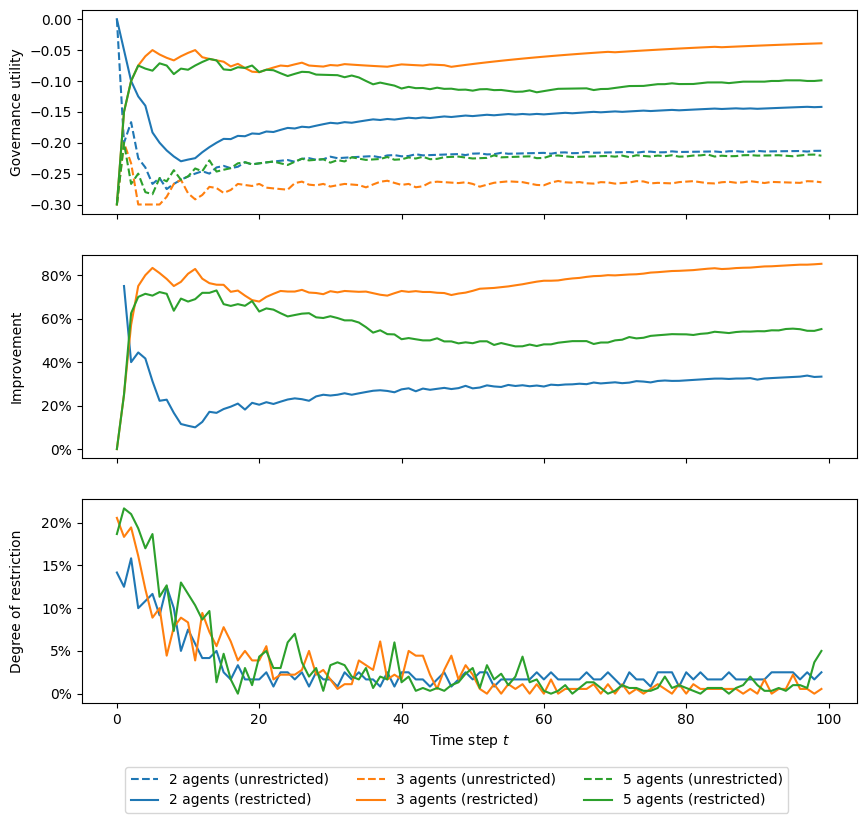

In [113]:
numbers_of_agents = [2, 3, 5]
colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
line_styles = {'unrestricted': 'dashed', 'restricted': 'solid'}

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

for number_of_agents in numbers_of_agents:
    ax1.plot(governance_utility[f'{number_of_agents} agents (unrestricted)'], color=colors[number_of_agents], label='Unrestricted', linestyle=line_styles['unrestricted'])
    ax1.plot(governance_utility[f'{number_of_agents} agents (restricted)'], color=colors[number_of_agents], label='Restricted', linestyle=line_styles['restricted'])

    ax2.plot(improvement[f'{number_of_agents} agents (restricted)'], color=colors[number_of_agents], label=f'{number_of_agents} agents')

    ax3.plot(degree_of_restriction[f'{number_of_agents} agents (restricted)'], color=colors[number_of_agents], label=f'{number_of_agents} agents')

lgd = fig.legend(labels=[f'{number_of_agents} agents ({type})' for number_of_agents in numbers_of_agents for type in ['unrestricted', 'restricted']], 
    loc='outside lower center', 
    ncol=3,
    bbox_to_anchor=(0.5, -0.02))

ax1.set_ylabel('Governance utility')

ax2.set_ylabel(r'Improvement')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.set_xlabel(r'Time step $t$')
ax3.set_ylabel('Degree of restriction')
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))

fig.align_labels()

# Save graph
results_path = './results/'
if not os.path.exists(results_path):
    os.makedirs(results_path)
fig.savefig(f'./results/graph.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')